In [69]:
#importamos las librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#leemos el datraframe y seleccionamos las columnas que vamos a usar 
df = pd.read_csv('../data/raw/StackOverflow.csv')
df = df[['matlab','month']]
df_matlab = pd.DataFrame(df)


In [3]:
# Utilizamos las funciones para cambiarle el formato, y aplicamos el formato que nos interesa mes, año
df_matlab['date'] = pd.to_datetime(df_matlab['month'], format="%y-%b")
df_matlab = df_matlab.set_index('date')
df_matlab = df_matlab.drop(columns='month')
df_matlab.index = pd.PeriodIndex(df_matlab.index, freq="M")
df_matlab

,matlab
date,
2009-01,19
2009-02,27
2009-03,24
2009-04,32
2009-05,42
...,...
2019-08,371
2019-09,362
2019-10,523


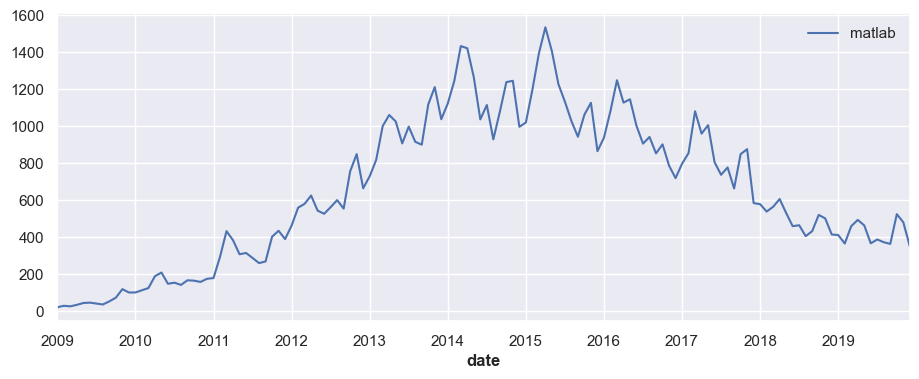

In [155]:
# imprimimos la serie temporal de las búsquedas en en matlab
sns.set(rc={'figure.figsize':(11, 4)})
ax = df_matlab.plot(linestyle='-')

In [5]:
# Log Transformer Function
from sktime.transformations.series.boxcox import LogTransformer

In [6]:
transformer = LogTransformer()
log_matlab_ts= transformer.fit_transform(df_matlab)

In [7]:
import statsmodels.api as sm

Text(0.5, 1.0, 'Comportamiento Estacional')

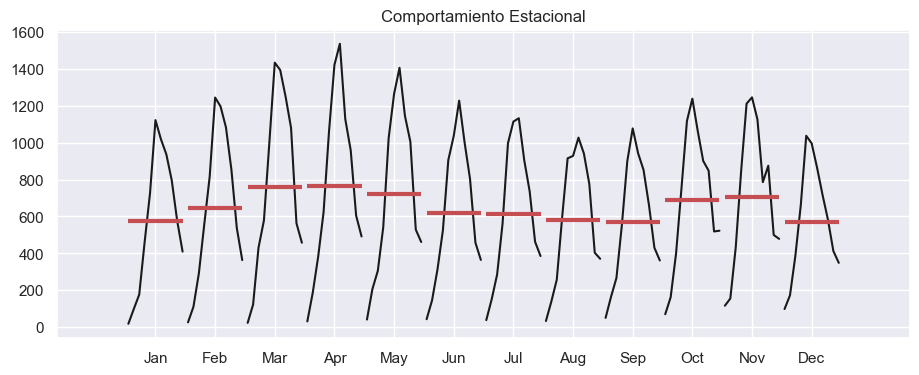

In [8]:
# Plot Quarterplot
ax = plt.gca()
sm.graphics.tsa.month_plot(df_matlab,ax=ax)
ax.set_title('Comportamiento Estacional')

No tiene estacionalidad ni en media, ni en varianza

Separamos entre train y test, posteriormente separaremos entre train y validación 

In [9]:
# Sktime fucntions
# Forecast horizon and Split functions 
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [10]:
n_test=6
n_forecast=8
y_train, y_test = temporal_train_test_split(y =df_matlab, test_size=6)
log_y_train, log_y_test = temporal_train_test_split(y =log_matlab_ts, test_size=n_test)

# Time Series Size
print(y_train.shape[0], y_test.shape[0])


126 6


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

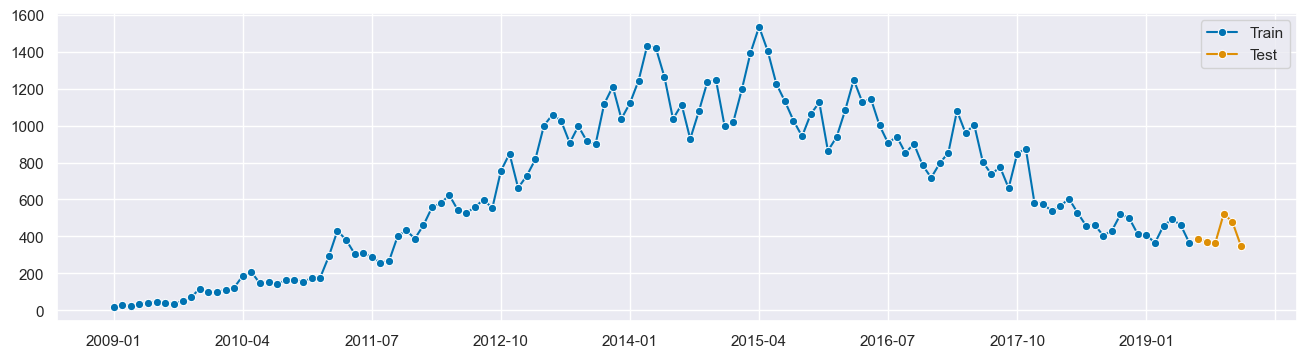

In [11]:
plot_series(y_train, y_test, labels=["Train", "Test"])


### Modelo ETS

In [12]:
from sktime.forecasting.ets import AutoETS

In [13]:
fh = np.arange(len(y_test)) + 1

In [14]:
matlab_autoETS_model = AutoETS(auto=True, sp=12, n_jobs=-1)

In [15]:
#  Auto ETS Model Estimation
matlab_autoETS_model.fit(y_train)

/Users/eduardo/opt/anaconda3/envs/PEDRICCION/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AutoETS(auto=True, n_jobs=-1, sp=12)

In [16]:
print(matlab_autoETS_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  126
Model:                       ETS(MAM)   Log Likelihood                -690.269
Date:                Mon, 21 Nov 2022   AIC                           1416.538
Time:                        20:40:51   BIC                           1467.591
Sample:                    01-31-2009   HQIC                          1437.279
                         - 06-30-2019   Scale                            0.015
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.8726      0.103      8.472      0.000       0.671       1.074
smoothing_trend         0.0244      0.019      1.309      0.191      -0.012       0.061
smoothing_season

In [125]:
#  Auto ETS Forecasting
matlab_ETS_pred1 = matlab_autoETS_model.predict(fh)
print(matlab_ETS_pred1)

             matlab
2019-07  342.565603
2019-08  306.406643
2019-09  303.428598
2019-10  353.941420
2019-11  366.699048
2019-12  293.079844


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

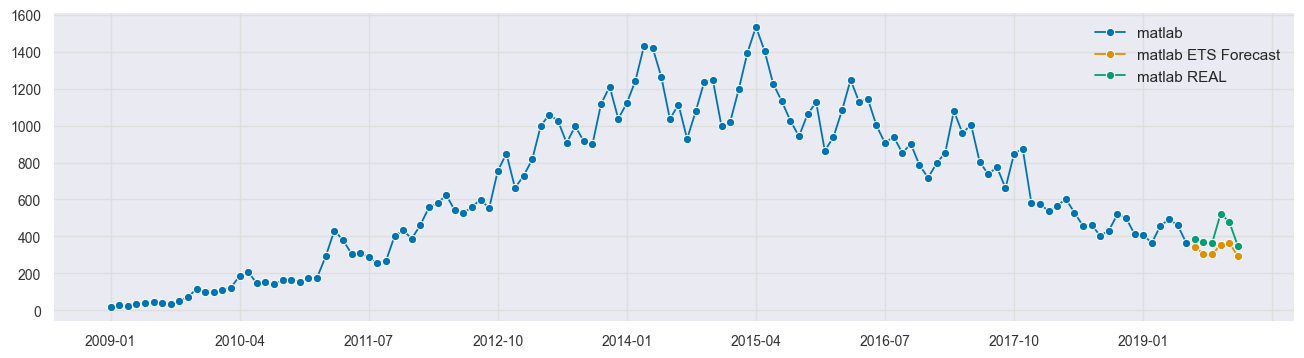

In [90]:
plot_series(y_train, matlab_ETS_pred1,y_test, labels=["matlab", "matlab ETS Forecast", "matlab REAL"])


In [19]:
mape_ETS = mean_absolute_percentage_error(y_test, matlab_ETS_pred)
mape_ETS

0.19439267845385802

### Modelo Arima

In [20]:
from sktime.forecasting.arima import AutoARIMA

In [21]:
forecaster = AutoARIMA(sp=12,suppress_warnings=True)

In [22]:
forecaster.fit(log_y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [23]:
print(forecaster.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  126
Model:             SARIMAX(4, 2, 1)x(1, 0, 1, 12)   Log Likelihood                  73.041
Date:                            Mon, 21 Nov 2022   AIC                           -128.082
Time:                                    20:42:12   BIC                           -102.699
Sample:                                01-31-2009   HQIC                          -117.771
                                     - 06-30-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.596      0.551      -0.000       0.000
ar.L1         -0.1264      0.087   

In [24]:
log_y_pred = forecaster.predict(fh)


In [25]:
matlab_ARIMA_pred=np.exp(log_y_pred)
matlab_ARIMA_pred

,matlab
2019-07,321.241644
2019-08,289.252713
2019-09,275.519762
2019-10,304.237410
2019-11,291.346721
2019-12,230.958731


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

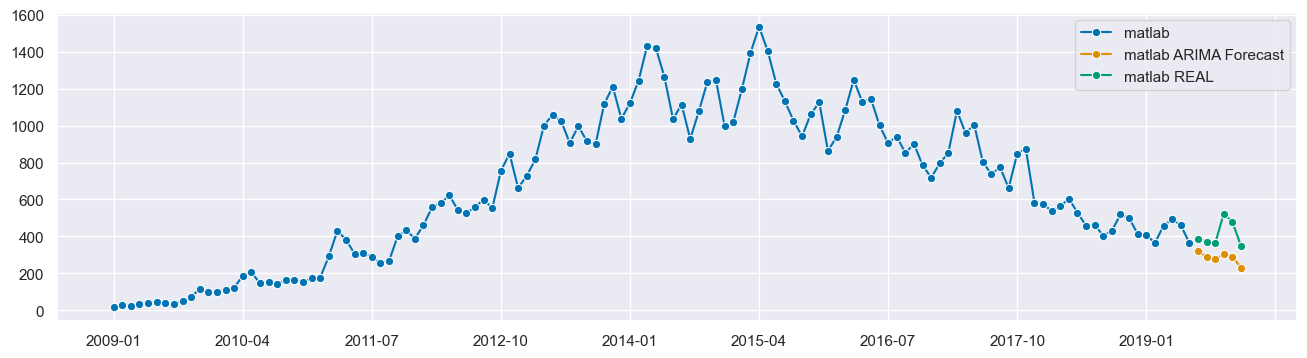

In [26]:
plot_series(y_train, matlab_ARIMA_pred,y_test, labels=["matlab", "matlab ARIMA Forecast", "matlab REAL"])

In [27]:
mape_ARIMA = mean_absolute_percentage_error(y_test, matlab_ARIMA_pred)
mape_ARIMA

0.2958797135668146

### modelo 4theta

In [28]:
from darts import TimeSeries

In [29]:
df['month'] = pd.to_datetime(df['month'], format= "%y-%b")

In [30]:
matlab =TimeSeries.from_dataframe(df, 'month', 'matlab')

In [31]:
x_train, x_val , x_test = matlab[:-18], matlab[-16:-6], matlab[-6:]

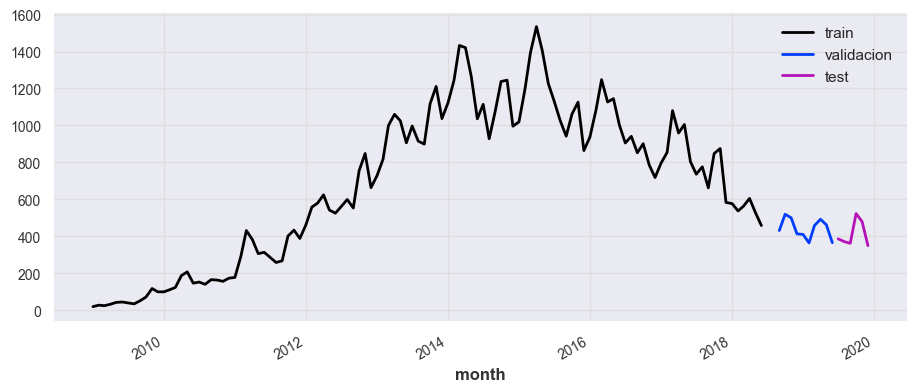

In [32]:
x_train.plot(label="train")
x_val.plot(label="validacion")
x_test.plot(label="test")

In [33]:
# %%
from darts.models import Theta, FourTheta
from darts.metrics import mape
model =FourTheta(seasonality_period=12) # Supone Theta 2
model.fit(x_train)
forecast = model.predict(len(x_val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(x_val, forecast)))

model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 185.97%


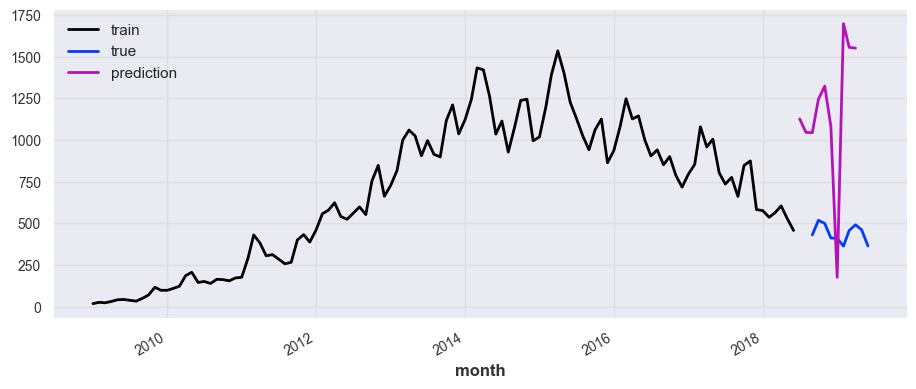

In [34]:
x_train.plot(label="train")
x_val.plot(label="true")
forecast.plot(label="prediction")

In [72]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
theta_grid = {
    'theta':2- np.linspace(-10, 10, 10),
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=x_train,
                                forecast_horizon=12,
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

2022-11-22 10:10:38 darts.models.forecasting.theta WARNING: Negative Theta line. Fallback to additive model
2022-11-22 10:10:38 darts.models.forecasting.theta WARNING: Negative Theta line. Fallback to additive model
/Users/eduardo/opt/anaconda3/envs/PEDRICCION/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/eduardo/opt/anaconda3/envs/PEDRICCION/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/eduardo/opt/anaconda3/envs/PEDRICCION/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/eduardo/opt/anaconda3/envs/PEDRICCION/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Chec

(<darts.models.forecasting.theta.FourTheta at 0x7fa3bed45e50>,
 {'theta': 0.8888888888888893,
  'model_mode': <ModelMode.ADDITIVE: 'additive'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 18.713270856289732)

Juntamos train y test

In [104]:
matlab__train, matlab__test = matlab[:-6], matlab[-6:]


In [105]:
modelo.fit(matlab__train)
pred_4theta_test = modelo.predict(len(matlab__test))

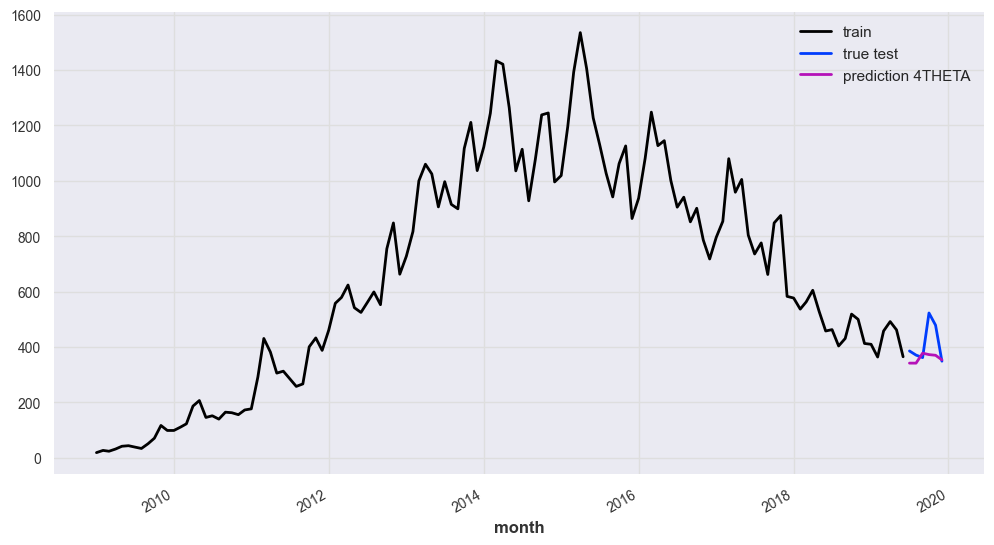

In [111]:
plt.rcParams["figure.figsize"] = (12,6)
matlab__train.plot(label="train")
matlab__test.plot(label="true test")
pred_4theta_test.plot(label="prediction 4THETA")

In [112]:
mape_4THETA = mape(matlab__test, pred_4theta_test)
mape_4THETA

12.733311989151321

## Cross validation 4THETA

  0%|          | 0/23 [00:00<?, ?it/s]

MAPE = 18.53%


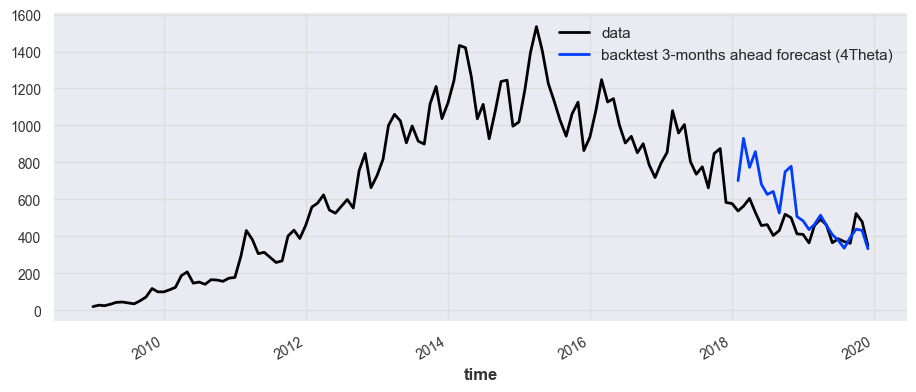

In [68]:
historical_fcast_4theta = modelo.historical_forecasts(matlab, start=0.75, forecast_horizon=12, verbose=True)

matlab.plot(label="data")
historical_fcast_4theta.plot(label="backtest 3-months ahead forecast (4Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_4theta, matlab)))

### Tbats Darts 
calculamos el tbats con la librería Darts, para seguir con el estudio 

In [76]:

# %%
from darts.models import TBATS
from darts.metrics import mape

model =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model.fit(x_train)
forecast = model.predict(len(x_val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(x_val, forecast)))


model (T)BATS obtains MAPE: 18.81%


In [77]:
model.model.params.summary()


'Use Box-Cox: True\nUse trend: True\nUse damped trend: False\nSeasonal periods: [12.]\nSeasonal harmonics [4]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 0.588066\nSmoothing (Alpha): 0.716842\nTrend (Beta): 0.045870\nDamping Parameter (Phi): 1.000000\nSeasonal Parameters (Gamma): [-4.50623087e-08 -1.64777249e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [ 3.38931205  1.9926666   0.9802564  -4.50308177 -2.28279818  0.84055225\n  4.80048138 -0.31667309  0.79650285  1.56966562]\n'

juntamos val y test y predecimos con test

In [103]:
matlab__train, matlab__test = matlab[:-6], matlab[-6:]

model.fit(matlab__train)
pred_tbats_test = model.predict(len(matlab__test))

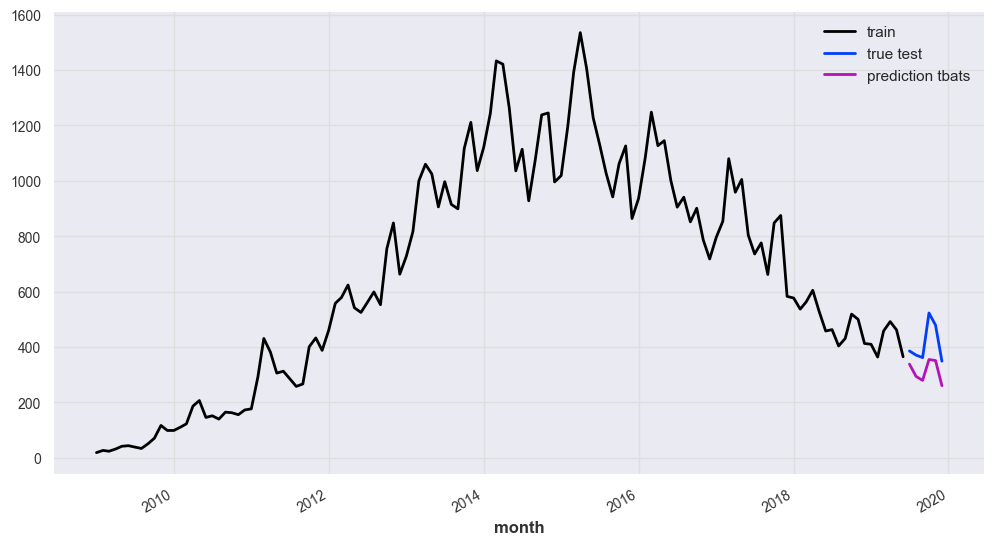

In [110]:
plt.rcParams["figure.figsize"] = (12,6)
matlab__train.plot(label="train")
matlab__test.plot(label="true test")
pred_tbats_test.plot(label="prediction tbats")

In [108]:
TBATS_mape = mape(matlab__test, pred_tbats_test)
TBATS_mape

23.307091816401368

## Cross validation TBATS

  0%|          | 0/23 [00:00<?, ?it/s]

MAPE = 37.33%


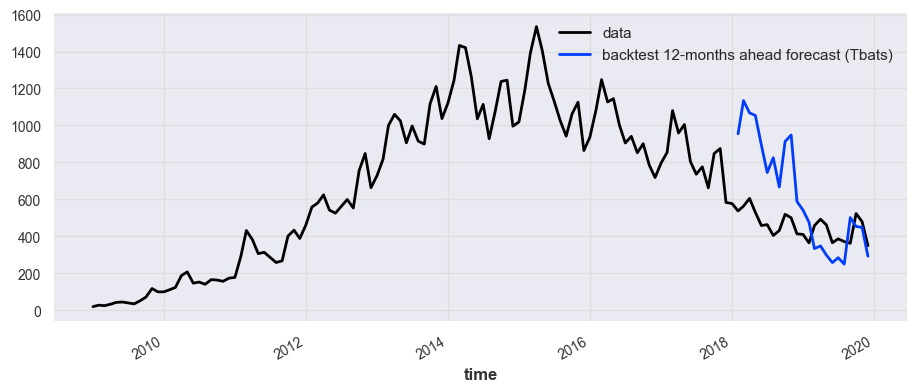

In [84]:

# %%
historical_fcast_tbats = model.historical_forecasts(
    matlab, start=0.75, forecast_horizon=12, verbose=True, stride=1
)

matlab.plot(label="data")
historical_fcast_tbats.plot(label="backtest 12-months ahead forecast (Tbats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_tbats, matlab)))

### Comparacion grafica de modelos

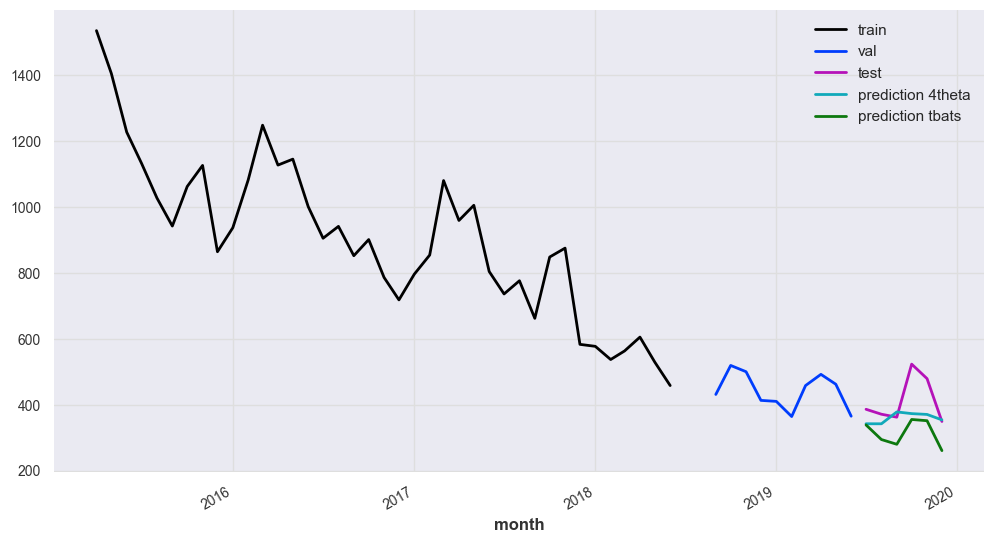

In [127]:
plt.rcParams["figure.figsize"] = (12,6)
x_train[75:].plot(label="train")
x_val.plot(label="val")
x_test.plot(label="test")
pred_4theta_test.plot(label="prediction 4theta")
pred_tbats_test.plot(label="prediction tbats")

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

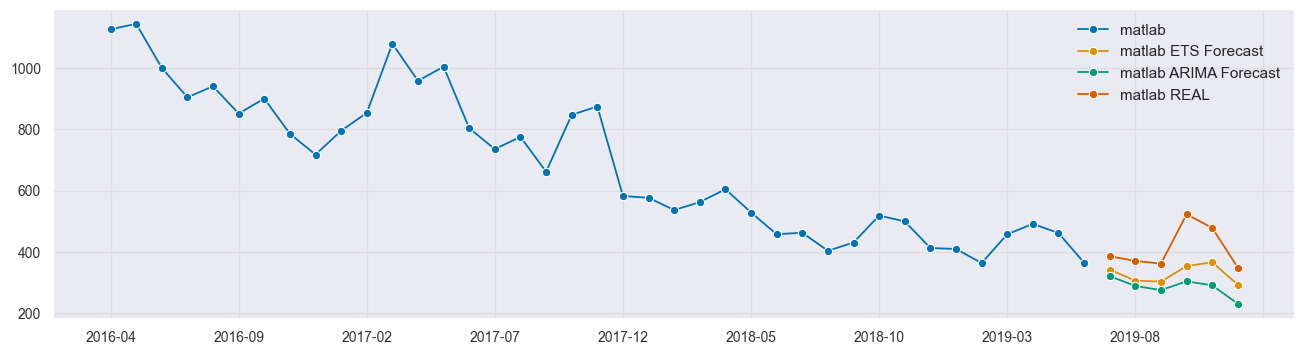

In [133]:
plot_series(y_train['2016-04':], matlab_ETS_pred1,matlab_ARIMA_pred,y_test, labels=["matlab", "matlab ETS Forecast","matlab ARIMA Forecast", "matlab REAL"])

# Mejor modelo
El modelo con menor MAPE es el modelo 4THETA con la libreria Darts, por lo tanto es que vamos a utlizar para realizar una predicción a 12 meses 

In [150]:
pred_4theta1 = modelo.predict(12)

In [154]:
pred_4theta = pred_4theta1.pd_dataframe()
pred_4theta

component,matlab
month,
2019-07-01,342.037263
2019-08-01,341.999046
2019-09-01,378.009592
2019-10-01,372.836447
2019-11-01,370.371104
2019-12-01,353.819087
2020-01-01,332.521918
2020-02-01,326.425026
2020-03-01,318.224991


ploteamos la grafica de 4 THETA con la predicción 

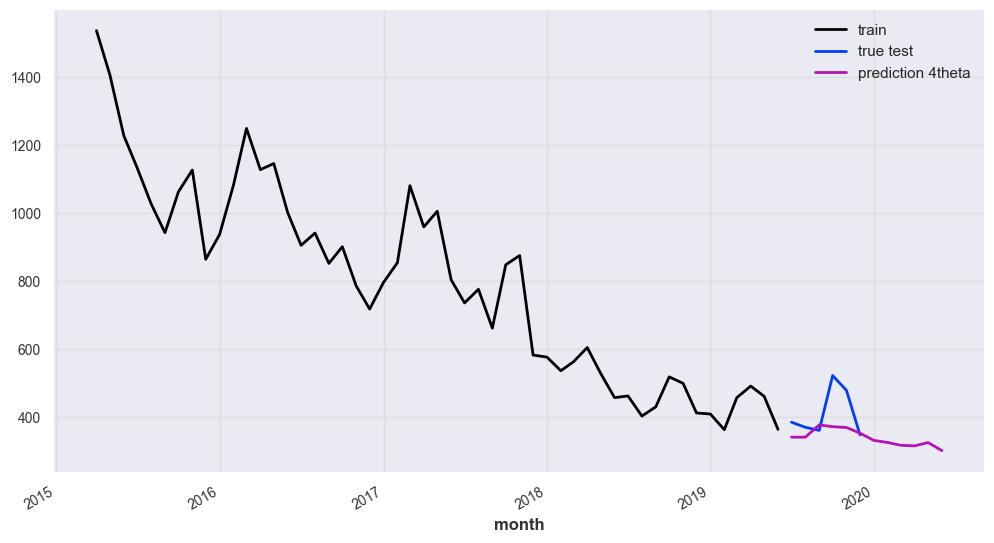

In [153]:
plt.rcParams["figure.figsize"] = (12,6)
matlab__train[75:].plot(label="train")
matlab__test.plot(label="true test")
pred_4theta1.plot(label="prediction 4theta")